# Titanic challenge from Kaggle
This is a challenge for beginners in Kaggle and can be accessed through https://www.kaggle.com/c/titanic/overview <br> <br>
The purpose of this notebook is to force myself to familiarise with Pandas dataframes and some basic classification/ML algorithms in scikit-learn.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

# Reading tables
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

# Plotting top 5 rows just for a quick visualisation
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


<img src="Images/DataDictionary.png">

In [2]:
# Just checking all types we have in the dataframe
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [3]:
# Having an initial look at correlation after a couple of changes to the dataframe
# (Male = 0, Female = 1)
df_train['Sex'] = df_train['Sex'].map( {'female': 1, 'male': 0} ).astype(int)
df_test['Sex']  = df_test['Sex'].map( {'female': 1, 'male': 0} ).astype(int)
df_train['FamilySize'] = df_train['Parch'] + df_train['SibSp'] + 1
df_test['FamilySize']  = df_test['Parch'] + df_test['SibSp'] + 1

<AxesSubplot:>

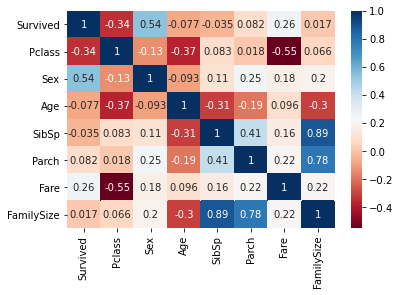

In [4]:
df_initial_corr = df_train.drop(['PassengerId','Name','Ticket','Cabin','Embarked'], axis=1)
sns.heatmap(df_initial_corr.astype(float).corr(), vmax=1.0, cmap=plt.cm.RdBu, annot=True)

## Analysing data by pivoting
From https://www.kaggle.com/startupsci/titanic-data-science-solutions

In [5]:
# Survival rate by class
df_train[['Survived','Pclass']].groupby(['Pclass']).mean().sort_values('Survived', ascending=False)

,Survived
Pclass,
1,0.629630
2,0.472826
3,0.242363


In [6]:
# Survival rate by sex
df_train[['Survived','Sex']].groupby(['Sex']).mean().sort_values('Sex', ascending=False)

,Survived
Sex,
1,0.742038
0,0.188908


## Histograms and bar plots
Maybe we can identify certain distributions here!

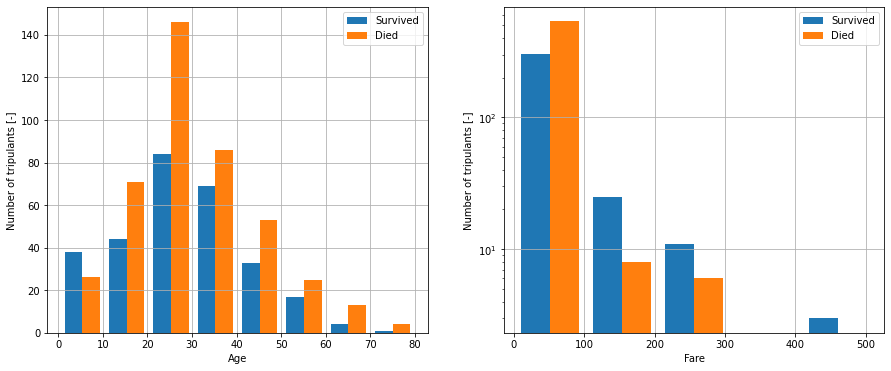

In [7]:
hist2plot = ['Age', 'Fare']
nBinsMap = [8,5]

f = plt.figure(figsize=(15,6))

for ii, column in enumerate(hist2plot):

    x1 = df_train[df_train['Survived'] == 1][column]
    x2 = df_train[df_train['Survived'] == 0][column]

    plt.subplot(1, 2, ii+1)
    plt.hist([x1,x2], bins=nBinsMap[ii])
    plt.xlabel(column)
    plt.ylabel('Number of tripulants [-]')
    plt.legend(['Survived','Died'])
    plt.grid()
    
    if column == 'Fare':
        plt.yscale('log', nonposy='clip')

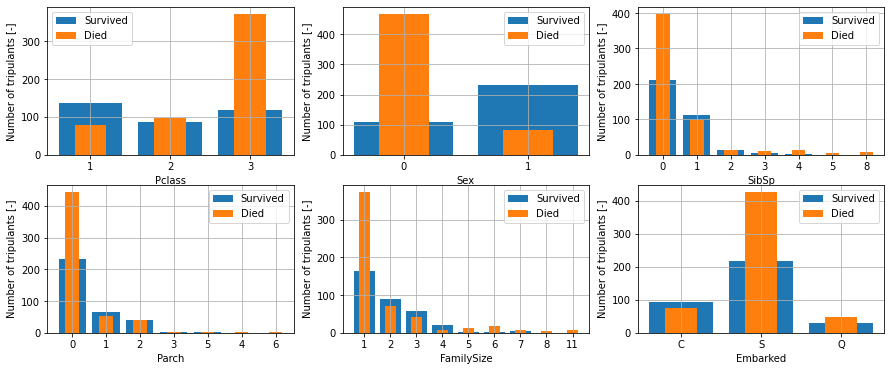

In [8]:
bar2plot = ['Pclass', 'Sex', 'SibSp', 'Parch', 'FamilySize', 'Embarked']
f = plt.figure(figsize=(15,6))

for ii, column in enumerate(bar2plot):
    
    if df_train[column].dtype == 'O':
        x1 = df_train[df_train['Survived'] == 1][column].dropna().unique()
        x2 = df_train[df_train['Survived'] == 0][column].dropna().unique()
        x1str = df_train[df_train['Survived'] == 1][column].dropna().astype(str).unique()
        x2str = df_train[df_train['Survived'] == 0][column].dropna().astype(str).unique()
    else:
        x1 = df_train[df_train['Survived'] == 1][column].dropna().sort_values().unique()
        x2 = df_train[df_train['Survived'] == 0][column].dropna().sort_values().unique()
        x1str = df_train[df_train['Survived'] == 1][column].dropna().sort_values().astype(str).unique()
        x2str = df_train[df_train['Survived'] == 0][column].dropna().sort_values().astype(str).unique()
        
    y1 = []
    y2 = []
    for jj in x1:
        y1.append(df_train.loc[(df_train['Survived'] == 1) & (df_train[column] == jj)][column].shape[0])
    for jj in x2:
        y2.append(df_train.loc[(df_train['Survived'] == 0) & (df_train[column] == jj)][column].shape[0])

    plt.subplot(2, 3, ii+1)
    plt.bar(x1str,y1)
    plt.bar(x2str,y2,width=0.4)
    plt.xlabel(column)
    plt.ylabel('Number of tripulants [-]')
    plt.legend(['Survived','Died'])
    plt.grid()

# Feature engineering
I will split the data set into two: <br>
1) One will remain more or less how it currently is, but without NaNs; <br>
2) The other will have categorised data (e.g. ages, fares and etc will be split into categories). <br> <br>
Most of this work is based on: <br>
https://towardsdatascience.com/feature-engineering-for-machine-learning-3a5e293a5114 <br>
https://www.kaggle.com/arthurtok/introduction-to-ensembling-stacking-in-python

In [9]:
df_train_cat = df_train.copy()
df_test_cat = df_test.copy()

alldata = [df_train, df_test, df_train_cat, df_test_cat]

# Filling NaN values with:
# 1) median for the age using train dataset;
# 2) most common value for "Embarked", as there are only two NaNs and they are statistically irrelevant.
# Also creating a "Family size" column, which is a combination of "Parch" and "SibSp".
for dataset in alldata:
    dataset['Age'].fillna(df_train['Age'].median(), inplace=True)
    dataset['Embarked'].fillna(df_train['Embarked'].value_counts().idxmax(), inplace=True)
    
# One-hot-encoding of embarked variables and dropping other columns that are not useful for prediction
for dataset in alldata:
    dataset[['Emb_Q','Emb_S']] = pd.get_dummies(dataset['Embarked'], drop_first=True)
    dataset.drop(['PassengerId', 'Name', 'Embarked', 'Ticket', 'Cabin'], axis=1, inplace=True)

Just checking the distribution of our data across certain domains:

Text(0.5, 1.0, 'Pclass Vs FamilySize distribution')

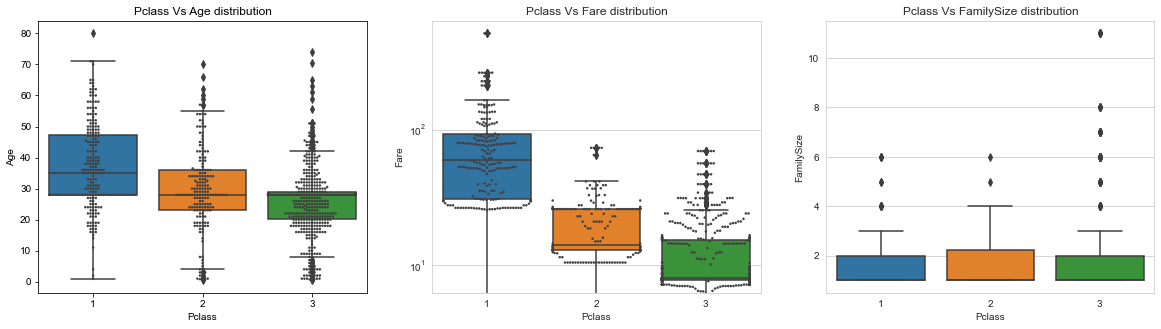

In [10]:
fig = plt.figure(figsize=(20,5))
plt.subplot(1,3,1)
sns.set_style("whitegrid")
sns.boxplot(x="Pclass", y="Age", data=df_train)
sns.swarmplot(x="Pclass", y="Age", data=df_train, color=".25", size=2.5)
plt.title('Pclass Vs Age distribution')

plt.subplot(1,3,2)
sns.set_style("whitegrid")
sns.boxplot(x="Pclass", y="Fare", data=df_train)
sns.swarmplot(x="Pclass", y="Fare", data=df_train, color=".25", size=2.5)
plt.title('Pclass Vs Fare distribution')
plt.yscale('log', nonposy='clip')

plt.subplot(1,3,3)
sns.set_style("whitegrid")
sns.boxplot(x="Pclass", y="FamilySize", data=df_train)
plt.title('Pclass Vs FamilySize distribution')


I won't drop any of the data based on outlider detection using percentiles, as they are all genuine data. <br>
Now let's categorise (binning) some of the data, which we will also used on more generalised models that will probably be worse at predictions, but this is a good exercise to be done anyway.

In [11]:
catdata = [df_train_cat, df_test_cat]

for dataset in catdata:
    dataset['AgeGroup'] = pd.qcut(dataset['Age'], q=4, labels=False)
    dataset['FareGroup'] = pd.qcut(dataset['Fare'], q=4, labels=False)
    dataset.drop(['Age', 'Fare'], axis=1, inplace=True)
    
df_train_cat.head()

,Survived,Pclass,Sex,SibSp,Parch,FamilySize,Emb_Q,Emb_S,AgeGroup,FareGroup
0,0,3,0,1,0,2,0,1,0,0
1,1,1,1,1,0,2,0,0,3,3
2,1,3,1,0,0,1,0,1,1,1
3,1,1,1,1,0,2,0,1,2,3
4,0,3,0,0,0,1,0,1,2,1


# Starting with simple classification algorithms
We can observe some trends from the plots above, so let's see what our models will tell us.
First inspiration coming from https://www.kaggle.com/startupsci/titanic-data-science-solutions, but we will move into XGBoost for hyperparameter optimisation later.

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

In [13]:
X = df_train.drop('Survived', axis=1)
y = df_train['Survived']
Xcat = df_train_cat.drop('Survived', axis=1)
ycat = df_train_cat['Survived']

# We don't have the results for the test dataset that has been provided, so we
# will just split the train dataset to generate our actual train and test sets.
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=42 )
Xcat_train, Xcat_test, ycat_train, ycat_test = train_test_split( Xcat, ycat, test_size=0.2, random_state=42 )

In [14]:
X_train.shape, y_train.shape, Xcat_train.shape, ycat_train.shape, X_test.shape, y_test.shape, Xcat_test.shape, ycat_test.shape

((712, 9), (712,), (712, 9), (712,), (179, 9), (179,), (179, 9), (179,))

In [15]:
from sklearn.preprocessing import MinMaxScaler

Scaler = MinMaxScaler()
ScalerCat = MinMaxScaler()

X_train = Scaler.fit_transform(X_train)
X_test = Scaler.transform(X_test)

Xcat_train = ScalerCat.fit_transform(Xcat_train)
Xcat_test = ScalerCat.transform(Xcat_test)

In [16]:
logreg = LogisticRegression()
svc = SVC()
knn = KNeighborsClassifier(n_neighbors = 3)
gaussian = GaussianNB()
linear_svc = LinearSVC()
sgd = SGDClassifier()
decision_tree = DecisionTreeClassifier()
random_forest = RandomForestClassifier(n_estimators=100)

models = [logreg, svc, knn, gaussian, linear_svc, sgd, decision_tree, random_forest]

train_score = []
test_score = []
for model in models:
    model.fit(X_train, y_train)
    train_score.append(round(model.score(X_train, y_train) * 100, 2))
    test_score.append(round(model.score(X_test, y_test) * 100, 2))

modelstr = [str(model) for model in models]
ModelsSummary = pd.DataFrame({'Train score': train_score, 'Test score': test_score}, index=modelstr)
ModelsSummary

,Train score,Test score
LogisticRegression(),79.78,79.89
SVC(),81.60,79.33
KNeighborsClassifier(n_neighbors=3),87.22,78.77
GaussianNB(),79.07,78.21
LinearSVC(),79.92,78.77
SGDClassifier(),77.81,80.45
DecisionTreeClassifier(),97.89,78.77
RandomForestClassifier(),97.89,82.68


From the table above, we can see that KNN, Decision Tree and Random Forest are overfitting. <br>
Now, we should do some optimisation of hypterparameters using XGBoost.

# Hyperparameter optimisation with XGBoost (commented out)

import xgboost as xgb

xgbclass = xgb.XGBClassifier(random_state=42, verbosity=0)
xgbclass.fit(X_train, y_train)

modelstr.append('XGBClassifier()')
train_score.append(round(xgbclass.score(X_train, y_train) * 100, 2))
test_score.append(round(xgbclass.score(X_test, y_test) * 100, 2))

ModelsSummary = pd.DataFrame({'Model': modelstr, 'Train score': train_score, 'Test score': test_score})
ModelsSummary

XGB is also overfitting with its standard settings. Let's see how the hyperparameters can help with this.

# Grid Search model tuning

In [17]:
from sklearn.model_selection import GridSearchCV

## Logistic regression

In [34]:
logregCV = LogisticRegression()
param_grid = {'C': [0.1, 1.0, 10, 100]}
logreg_gridsearch = GridSearchCV(logregCV, param_grid, cv=5, scoring='accuracy')
logreg_gridsearch.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [0.1, 1.0, 10, 100]}, scoring='accuracy')

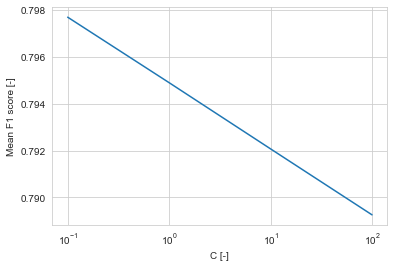

In [35]:
plt.figure()
plt.plot(param_grid['C'], logreg_gridsearch.cv_results_['mean_test_score'])
plt.xscale('log')
plt.xlabel('C [-]')
plt.ylabel('Mean F1 score [-]')
plt.show()

We can see that there is not much that we can do with logistic regression

In [36]:
logreg_gridsearch.score(X_test, y_test)

0.7821229050279329

## SVC with RBF

In [37]:
svcCV = SVC()
param_grid = {'C': [0.1, 1.0, 10, 100, 1000], 'gamma': [0.001, 0.01, 0.1, 1.0, 10]}
svc_gridsearch = GridSearchCV(svcCV, param_grid, cv=5, scoring='accuracy')
svc_gridsearch.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [0.1, 1.0, 10, 100, 1000],
                         'gamma': [0.001, 0.01, 0.1, 1.0, 10]},
             scoring='accuracy')

Text(0.5, 1.0, 'Mean F1 score')

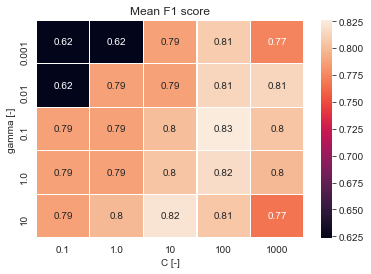

In [38]:
z = svc_gridsearch.cv_results_['mean_test_score'].reshape(len(param_grid['C']), len(param_grid['gamma']))
plt.figure()
#plt.pcolormesh(z)
sns.heatmap(z, linewidth=0.3, annot=True, xticklabels=param_grid['C'], yticklabels=param_grid['gamma'])
plt.xlabel('C [-]')
plt.ylabel('gamma [-]')
plt.title('Mean F1 score')

In [39]:
svc_gridsearch.score(X_test, y_test)

0.8156424581005587

There wasn't much improvement for SVC with RBF kernel too.

## SVC with polynomial kernel

In [40]:
svcPolyCV = SVC(kernel='poly')
param_grid = {'C': [1.0, 10], 'gamma': [1.0, 10], 'degree': [2, 3, 4]}
svcPoly_gridsearch = GridSearchCV(svcPolyCV, param_grid, cv=5, scoring='accuracy')
svcPoly_gridsearch.fit(X_train, y_train)
svcPoly_gridsearch.best_estimator_

SVC(C=10, degree=4, gamma=1.0, kernel='poly')

In [41]:
svcPoly_gridsearch.cv_results_['mean_test_score']

array([0.79771496, 0.80755442, 0.81038117, 0.80754457, 0.81740372,
       0.81457697, 0.81037132, 0.81037132, 0.81877278, 0.80620506,
       0.82440658, 0.7865163 ])

Text(0, 0.5, 'Mean test score')

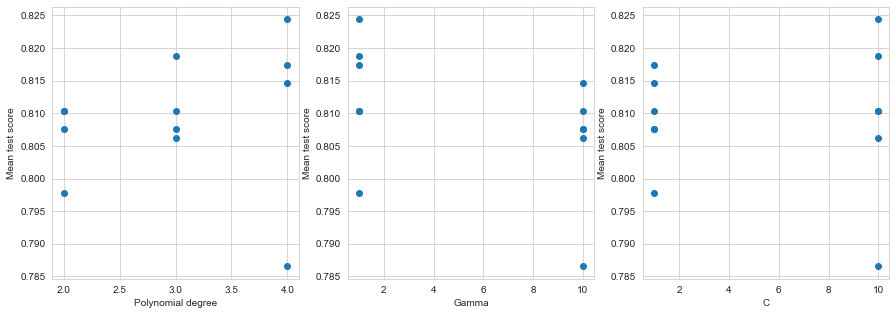

In [42]:
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.scatter(svcPoly_gridsearch.cv_results_['param_degree'].data, svcPoly_gridsearch.cv_results_['mean_test_score'])
plt.xlabel('Polynomial degree')
plt.ylabel('Mean test score')

plt.subplot(1,3,2)
plt.scatter(svcPoly_gridsearch.cv_results_['param_gamma'].data, svcPoly_gridsearch.cv_results_['mean_test_score'])
plt.xlabel('Gamma')
plt.ylabel('Mean test score')

plt.subplot(1,3,3)
plt.scatter(svcPoly_gridsearch.cv_results_['param_C'].data, svcPoly_gridsearch.cv_results_['mean_test_score'])
plt.xlabel('C')
plt.ylabel('Mean test score')

It looks like we need high polynomial degree and possibly high C, so let's give another go with more of these.

In [26]:
svcPolyCV = SVC(kernel='poly', gamma=1.0)
param_grid = {'C': [1.0, 10, 100], 'degree': [3, 4, 5, 6]}
svcPoly_gridsearch = GridSearchCV(svcPolyCV, param_grid, cv=5, scoring='f1')
svcPoly_gridsearch.fit(X_train, y_train)
svcPoly_gridsearch.best_estimator_

SVC(degree=6, gamma=1.0, kernel='poly')

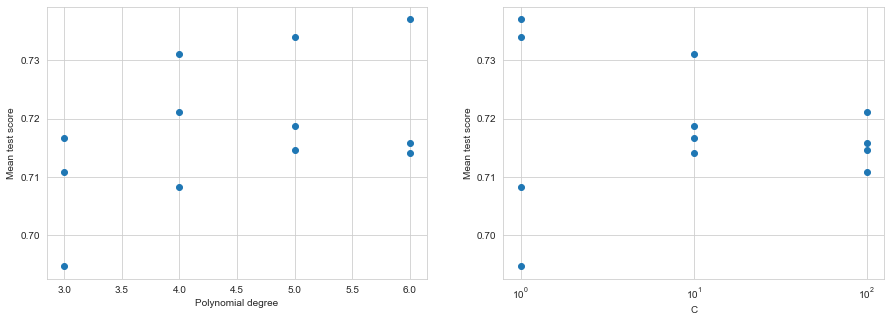

In [27]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.scatter(svcPoly_gridsearch.cv_results_['param_degree'].data, svcPoly_gridsearch.cv_results_['mean_test_score'])
plt.xlabel('Polynomial degree')
plt.ylabel('Mean test score')

plt.subplot(1,2,2)
plt.scatter(svcPoly_gridsearch.cv_results_['param_C'].data, svcPoly_gridsearch.cv_results_['mean_test_score'])
plt.xlabel('C')
plt.ylabel('Mean test score')
plt.xscale('log')

One final go with low C and high degree.

In [28]:
svcPolyCV = SVC(kernel='poly', gamma=1.0)
param_grid = {'C': [0.01, 0.1, 1.0, 10, 100], 'degree': [5, 6, 7]}
svcPoly_gridsearch = GridSearchCV(svcPolyCV, param_grid, cv=5, scoring='f1')
svcPoly_gridsearch.fit(X_train, y_train)
svcPoly_gridsearch.best_estimator_

SVC(degree=6, gamma=1.0, kernel='poly')

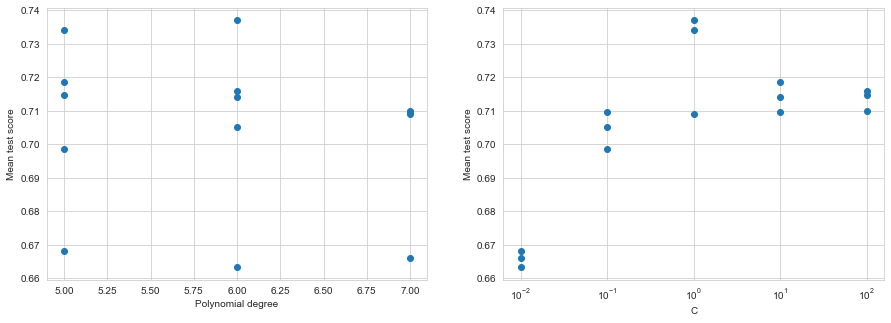

In [29]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.scatter(svcPoly_gridsearch.cv_results_['param_degree'].data, svcPoly_gridsearch.cv_results_['mean_test_score'])
plt.xlabel('Polynomial degree')
plt.ylabel('Mean test score')

plt.subplot(1,2,2)
plt.scatter(svcPoly_gridsearch.cv_results_['param_C'].data, svcPoly_gridsearch.cv_results_['mean_test_score'])
plt.xlabel('C')
plt.ylabel('Mean test score')
plt.xscale('log')

It looks like C = 1 and degree = 6 are our best options.

## Random forest

In [30]:
rfcCV = RandomForestClassifier(random_state=42)
param_grid = {'n_estimators': [8, 16, 32, 64, 128], 'max_depth': [4, 6, 8, 10]}
rfcCV_gridsearch = GridSearchCV(rfcCV, param_grid, cv=5, scoring='f1')
rfcCV_gridsearch.fit(X_train, y_train)
rfcCV_gridsearch.best_estimator_

RandomForestClassifier(max_depth=8, n_estimators=128, random_state=42)

Text(0, 0.5, 'Mean test score')

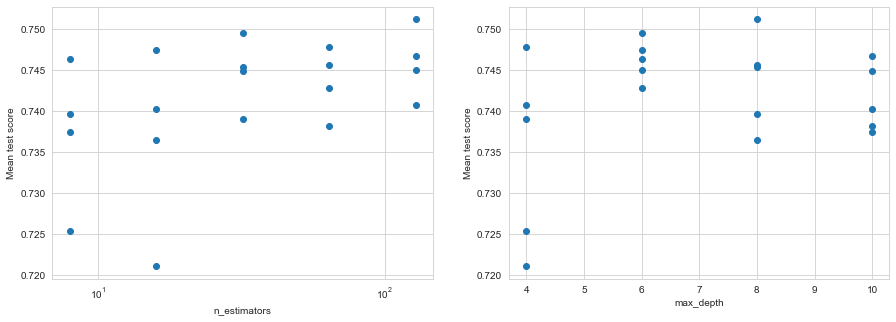

In [31]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.scatter(rfcCV_gridsearch.cv_results_['param_n_estimators'].data, rfcCV_gridsearch.cv_results_['mean_test_score'])
plt.xlabel('n_estimators')
plt.ylabel('Mean test score')
plt.xscale('log')

plt.subplot(1,2,2)
plt.scatter(rfcCV_gridsearch.cv_results_['param_max_depth'].data, rfcCV_gridsearch.cv_results_['mean_test_score'])
plt.xlabel('max_depth')
plt.ylabel('Mean test score')

Second attempt with higher number of estimators

In [32]:
rfcCV = RandomForestClassifier(random_state=42)
param_grid = {'n_estimators': [32, 64, 128, 256, 512], 'max_depth': [6, 8, 10, 12]}
rfcCV_gridsearch = GridSearchCV(rfcCV, param_grid, cv=5, scoring='f1')
rfcCV_gridsearch.fit(X_train, y_train)
rfcCV_gridsearch.best_estimator_

RandomForestClassifier(max_depth=8, n_estimators=512, random_state=42)

Text(0, 0.5, 'Mean test score')

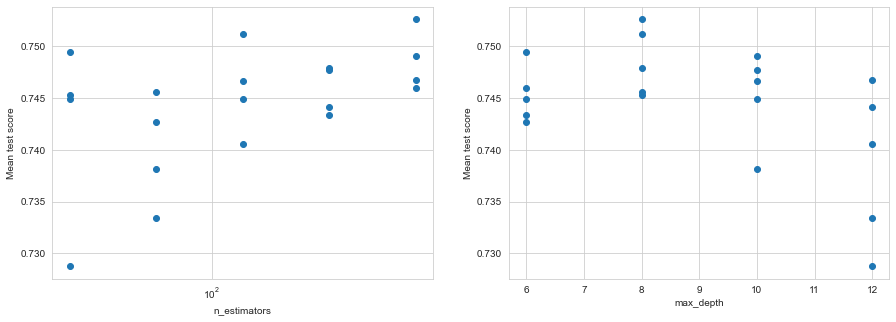

In [33]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.scatter(rfcCV_gridsearch.cv_results_['param_n_estimators'].data, rfcCV_gridsearch.cv_results_['mean_test_score'])
plt.xlabel('n_estimators')
plt.ylabel('Mean test score')
plt.xscale('log')

plt.subplot(1,2,2)
plt.scatter(rfcCV_gridsearch.cv_results_['param_max_depth'].data, rfcCV_gridsearch.cv_results_['mean_test_score'])
plt.xlabel('max_depth')
plt.ylabel('Mean test score')